<h1 align="center">Evaluating Evals for Retrieval Relevance</h1>

I created this notebook to compare Atla Selene against GPT4 via Phoenix Arize (I omitted GPT4o due to technical reasons), by creating a straightforward evaluation of the models' performance when classifying the relevance or irrelevance of documents retrieved by RAG. To determine relevance to the corresponding query, I compared their predictions against ground-truth labels from the Wiki_QA-Train benchmark dataset. 

It should come as no surprise that **Atlas Selene** came out on top on account of:
- Accuracy. It was 24% better than GPT4
- Higher precision on 'Relevant' class (1.00 vs 0.56). GPT4 had more False Positives.
- Very clean confusion matrix, with low misclassification rate (False Positive / False Negative both minimal)
- Atla's performance is more balanced between classes, as seen from the identical Macro F1 and Weighted F1

Time and budget permitting, I would have liked to run a comprehensive benchmarking on the full dataset, and pit Atla Selene against Claude, Gemini, Llama, and Mistral across all the metrics.

## Environment setup

In [ ]:
pip install atla dotenv -q

In [ ]:
pip install -qq "arize-phoenix-evals>=0.0.5" "openai>=1" ipython matplotlib pycm scikit-learn tiktoken nest_asyncio 'httpx<0.28' ipywidgets

In [ ]:
from dotenv import load_dotenv
import os

load_dotenv()
print(os.environ.get("ATLA_API_KEY"))

## Testing Atla's API key and scoring template

In [8]:
model_id="atla-selene"
metric_name = "atla_default_relevance"
evaluation_criteria="""
Compare the Question above to the Reference text. You must determine whether the model_output contains information that can answer the question in the model_input. 
Your response must be single word, either 'True' or 'False' and should not contain any text or characters aside from that word.
'False' means that model_output test does not contain an answer to the question in the model_input, that is the model_output is irrelevant.
'True' means the model_output text contains an answer to the question in the model_input, that is the model_output is relevant.
"""

In [3]:
import os
from atla import Atla

client = Atla(
    api_key=os.environ.get("ATLA_API_KEY"),
)

result = client.evaluation.create(
    model_id=model_id,
    model_input="who killed julius caesar",
    model_output="Gaius Julius Caesar (, July 100 BC – 15 March 44 BC) was a Roman general , statesman , Consul and notable author of Latin prose. He played a critical role in the events that led to the demise of the Roman Republic and the rise of the Roman Empire . In 60 BC, Caesar, Crassus and Pompey formed a political alliance that was to dominate Roman politics for several years. Their attempts to amass power through populist tactics were opposed by the conservative elite within the Roman Senate , among them Cato the Younger with the frequent support of Cicero . Caesar's conquest of Gaul , completed by 51 BC, extended Rome's territory to the English Channel and the Rhine . Caesar became the first Roman general to cross both when he built a bridge across the Rhine and conducted the first invasion of Britain . These achievements granted him unmatched military power and threatened to eclipse the standing of Pompey, who had realigned himself with the Senate after the death of Crassus in 53 BC. With the Gallic Wars concluded, the Senate ordered Caesar to lay down his military command and return to Rome. Caesar refused, and marked his defiance in 49 BC by crossing the Rubicon with a legion , leaving his province and illegally entering Roman territory under arms. Civil war resulted, from which he emerged as the unrivaled leader of Rome. After assuming control of government, Caesar began a program of social and governmental reforms, including the creation of the Julian calendar . He centralised the bureaucracy of the Republic and was eventually proclaimed 'dictator in perpetuity'. But the underlying political conflicts had not been resolved, and on the Ides of March (15 March) 44 BC, Caesar was assassinated by a group of senators led by Marcus Junius Brutus . A new series of civil wars broke out, and the constitutional government of the Republic was never restored. Caesar's adopted heir Octavian, later known as Augustus , rose to sole power, and the era of the Roman Empire began. Much of Caesar's life is known from his own accounts of his military campaigns, and from other contemporary sources, mainly the letters and speeches of Cicero and the historical writings of Sallust . The later biographies of Caesar by Suetonius and Plutarch are also major sources. Caesar is deemed to be one of the greatest military commanders of history.",
    evaluation_criteria=evaluation_criteria,
)

result_dict_sample = result.result.model_dump()
print(result_dict_sample)

{'evaluation': {'critique': "The response does not directly answer the question of who killed Julius Caesar. Instead, it provides a detailed biography of Julius Caesar, including his life, achievements, and death. While it mentions that Caesar was assassinated by a group of senators led by Marcus Junius Brutus, this information is buried within a lengthy passage and does not clearly address the user's question. To improve, the response should focus on providing a clear and concise answer to the user's question, rather than providing unnecessary background information.", 'score': 'False'}, 'model_id': 'atla-selene-20250214'}


## Download Benchmark Dataset

We'll evaluate the evaluation against benchmark datasets 'wiki_qa-train' of queries and retrieved documents with ground-truth relevance labels. However we'll only sample 30 examples from the benchmark dataset to optimise for run time on my local non-GPU device. 

In [52]:
import pandas as pd
from phoenix.evals import (
    RAG_RELEVANCY_PROMPT_RAILS_MAP,
    RAG_RELEVANCY_PROMPT_TEMPLATE,
    OpenAIModel,
    download_benchmark_dataset,
    llm_classify,
)

pd.set_option("display.max_colwidth", None)

df = download_benchmark_dataset(
    task="binary-relevance-classification", dataset_name="wiki_qa-train"
)
df.head()

,query_id,query_text,document_title,document_text,document_text_with_emphasis,relevant
0,Q1,how are glacier caves formed?,Glacier cave,"A partly submerged glacier cave on Perito Moreno Glacier . The ice facade is approximately 60 m high Ice formations in the Titlis glacier cave A glacier cave is a cave formed within the ice of a glacier . Glacier caves are often called ice caves , but this term is properly used to describe bedrock caves that contain year-round ice.","A partly submerged glacier cave on Perito Moreno Glacier . The ice facade is approximately 60 m high Ice formations in the Titlis glacier cave A GLACIER CAVE IS A CAVE FORMED WITHIN THE ICE OF A GLACIER . Glacier caves are often called ice caves , but this term is properly used to describe bedrock caves that contain year-round ice.",True
1,Q10,how an outdoor wood boiler works,Outdoor wood-fired boiler,The outdoor wood boiler is a variant of the classic wood stove adapted for set-up outdoors while still transferring the heat to interior buildings.,The outdoor wood boiler is a variant of the classic wood stove adapted for set-up outdoors while still transferring the heat to interior buildings.,False
2,Q100,what happens to the light independent reactions of photosynthesis?,Light-independent reactions,"The simplified internal structure of a chloroplast Overview of the Calvin cycle and carbon fixation The light-independent reactions of photosynthesis are chemical reactions that convert carbon dioxide and other compounds into glucose . These reactions occur in the stroma , the fluid-filled area of a chloroplast outside of the thylakoid membranes. These reactions take the light-dependent reactions and perform further chemical processes on them. There are three phases to the light-independent reactions, collectively called the Calvin cycle : carbon fixation, reduction reactions, and ribulose 1,5-bisphosphate (RuBP) regeneration. Despite its name, this process occurs only when light is available. Plants do not carry out the Calvin cycle by night. They, instead, release sucrose into the phloem from their starch reserves. This process happens when light is available independent of the kind of photosynthesis ( C3 carbon fixation , C4 carbon fixation , and Crassulacean Acid Metabolism ); CAM plants store malic acid in their vacuoles every night and release it by day in order to make this process work.","The simplified internal structure of a chloroplast Overview of the Calvin cycle and carbon fixation THE LIGHT-INDEPENDENT REACTIONS OF PHOTOSYNTHESIS ARE CHEMICAL REACTIONS THAT CONVERT CARBON DIOXIDE AND OTHER COMPOUNDS INTO GLUCOSE . These reactions occur in the stroma , the fluid-filled area of a chloroplast outside of the thylakoid membranes. THESE REACTIONS TAKE THE LIGHT-DEPENDENT REACTIONS AND PERFORM FURTHER CHEMICAL PROCESSES ON THEM. There are three phases to the light-independent reactions, collectively called the Calvin cycle : carbon fixation, reduction reactions, and ribulose 1,5-bisphosphate (RuBP) regeneration. Despite its name, this process occurs only when light is available. Plants do not carry out the Calvin cycle by night. They, instead, release sucrose into the phloem from their starch reserves. This process happens when light is available independent of the kind of photosynthesis ( C3 carbon fixation , C4 carbon fixation , and Crassulacean Acid Metabolism ); CAM plants store malic acid in their vacuoles every night and release it by day in order to make this process work.",True
3,Q1000,where in the bible that palestine have no land in jerusalem,Philistines,"The Philistine cities of Gaza, Ashdod, Ashkelon, Ekron, and Gath The Philistines (, , , or ; , Plištim), Pleshet or Peleset, were a people who as part of the Sea Peoples appeared in the southern coastal area of Canaan at the beginning of the Iron Age (circa 1175 BC), most probably from the Aegean region. According to the Bible , they ruled the five city-states (the ""Philistine Pentapolis"") of Gaza , 

In [53]:
df_sample = df.sample(n=30).reset_index(drop=True)
df_sample = df_sample.rename(
    columns={
        "query_text": "input",
        "document_text": "reference",
    },
)

display(df_sample.head())
df_sample.to_csv("benchmark_samples.csv", index=False)

,query_id,input,document_title,reference,document_text_with_emphasis,relevant
0,Q2717,what is pci Interface,Conventional PCI,"Conventional PCI (PCI is an initialism formed from Peripheral Component Interconnect, part of the PCI Local Bus standard and often shortened to just PCI) is a local computer bus for attaching hardware devices in a computer . The PCI bus supports the functions found on a processor bus , but in a standardized format that is independent of any particular processor. Devices connected to the bus appear to the processor to be connected directly to the processor bus, and are assigned addresses in the processor's address space. Attached devices can take either the form of an integrated circuit fitted onto the motherboard itself, called a planar device in the PCI specification, or an expansion card that fits into a slot. The PCI Local Bus was first implemented in IBM PC compatibles , where it displaced the combination of ISA plus one VESA Local Bus as the bus configuration. It has subsequently been adopted for other computer types. PCI and PCI-X are being replaced by PCI Express , but , most motherboards are still made with one or more PCI slots, which are sufficient for many uses. The PCI specification covers the physical size of the bus (including the size and spacing of the circuit board edge electrical contacts), electrical characteristics, bus timing, and protocols. The specification can be purchased from the PCI Special Interest Group (PCI-SIG). Typical PCI cards used in PCs include: network cards , sound cards , modems , extra ports such as USB or serial , TV tuner cards and disk controllers . PCI video cards replaced ISA and VESA cards, until growing bandwidth requirements outgrew the capabilities of PCI; the preferred interface for video cards became AGP , and then PCI Express. PCI video cards remain available for use with old PCs without AGP or PCI Express slots. Many devices previously provided on PCI expansion cards are now commonly integrated onto motherboards or available in universal serial bus and PCI Express versions.","CONVENTIONAL PCI (PCI IS AN INITIALISM FORMED FROM PERIPHERAL COMPONENT INTERCONNECT, PART OF THE PCI LOCAL BUS STANDARD AND OFTEN SHORTENED TO JUST PCI) IS A LOCAL COMPUTER BUS FOR ATTACHING HARDWARE DEVICES IN A COMPUTER . The PCI bus supports the functions found on a processor bus , but in a standardized format that is independent of any particular processor. Devices connected to the bus appear to the processor to be connected directly to the processor bus, and are assigned addresses in the processor's address space. Attached devices can take either the form of an integrated circuit fitted onto the motherboard itself, called a planar device in the PCI specification, or an expansion card that fits into a slot. The PCI Local Bus was first implemented in IBM PC compatibles , where it displaced the combination of ISA plus one VESA Local Bus as the bus configuration. It has subsequently been adopted for other computer types. PCI and PCI-X are being replaced by PCI Express , but , most motherboards are still made with one or more PCI slots, which are sufficient for many uses. The PCI specification covers the physical size of the bus (including the size and spacing of the circuit board edge electrical contacts), electrical characteristics, bus timing, and protocols. The specification can be purchased from the PCI Special Interest Group (PCI-SIG). Typical PCI cards used in PCs include: network cards , sound cards , modems , extra ports such as USB or serial , TV tuner cards and disk controllers . PCI video cards replaced ISA and VESA cards, until growing bandwidth requirements outgrew the capabilities of PCI; the preferred interface for video cards became AGP , and then PCI Express. PCI video cards remain available for use with old PCs without AGP or PCI Express slots. Many devices previously provided on PCI expansion cards are now commonly integrated onto motherboards or available in

## Relevance classifications with Atla Selene on the sample dataset

In [54]:
import nest_asyncio

nest_asyncio.apply() #Enables async request submission in notebooks to speed up inference

In [55]:
results_list = []

for idx, row in df_sample.iterrows():
    result = client.evaluation.create(
        model_id=model_id,
        model_input=row["input"],
        model_output=row["reference"],
        evaluation_criteria=evaluation_criteria,
        # metric_name=metric_name,
    )
    
    result_dict = result.result.model_dump()
    
    results_list.append({
        "model_input": row["input"],
        "model_output": row["reference"],
        "critique": result_dict['evaluation']['critique'],
        "score": result_dict['evaluation']['score'],
    })

# Convert to dataframe
results_df = pd.DataFrame(results_list)
display(results_df.head())

,model_input,model_output,critique,score
0,what is pci Interface,"Conventional PCI (PCI is an initialism formed from Peripheral Component Interconnect, part of the PCI Local Bus standard and often shortened to just PCI) is a local computer bus for attaching hardware devices in a computer . The PCI bus supports the functions found on a processor bus , but in a standardized format that is independent of any particular processor. Devices connected to the bus appear to the processor to be connected directly to the processor bus, and are assigned addresses in the processor's address space. Attached devices can take either the form of an integrated circuit fitted onto the motherboard itself, called a planar device in the PCI specification, or an expansion card that fits into a slot. The PCI Local Bus was first implemented in IBM PC compatibles , where it displaced the combination of ISA plus one VESA Local Bus as the bus configuration. It has subsequently been adopted for other computer types. PCI and PCI-X are being replaced by PCI Express , but , most motherboards are still made with one or more PCI slots, which are sufficient for many uses. The PCI specification covers the physical size of the bus (including the size and spacing of the circuit board edge electrical contacts), electrical characteristics, bus timing, and protocols. The specification can be purchased from the PCI Special Interest Group (PCI-SIG). Typical PCI cards used in PCs include: network cards , sound cards , modems , extra ports such as USB or serial , TV tuner cards and disk controllers . PCI video cards replaced ISA and VESA cards, until growing bandwidth requirements outgrew the capabilities of PCI; the preferred interface for video cards became AGP , and then PCI Express. PCI video cards remain available for use with old PCs without AGP or PCI Express slots. Many devices previously provided on PCI expansion cards are now commonly integrated onto motherboards or available in universal serial bus and PCI Express versions.","The response accurately defines what PCI Interface is, providing detailed information about its functionality, history, and applications. It effectively addresses the user's query by explaining the role of PCI in computer systems, its compatibility, and its evolution over time. The inclusion of specific examples of PCI cards and their uses enhances the clarity of the explanation. However, the response could be improved by being more concise and directly answering the question without unnecessary elaboration.",True
1,who created earth day,"The Earth Day Flag , the latest proposal of John McConnell for a flag of Earth Day Earth Day is an annual event, celebrated on April 22, on which events are held worldwide to demonstrate support for environmental protection. It was first celebrated in 1970, and is now coordinated globally by the Earth Day Network , and celebrated in more than 192 countries each year. In 1969 at a UNESCO Conference in San Francisco, the date proposed was March 21, 1970, the first day of spring in the northern hemisphere. This day of nature's equipoise was later sanctioned in a Proclamation signed by Secretary General U Thant at the United Nations . A month later a separate Earth Day was founded by United States Senator Gaylord Nelson as an environmental teach-in first held on April 22, 1970. Nelson was later awarded the Presidential Medal of Freedom Award in recognition of his work. While this April 22 Earth Day was focused on the United States, an organization launched by Denis Hayes , who was the original national coordinator in 1970, took it international in 1990 and organized events in 141 nations. Numerous communities celebrate Earth Week, an entire week of activities focused on environmental issues.","The response contains relevant information about the creation of Earth Day, mentioning key figures such as Senator Gaylord Nelson and Denis Hayes. However, it does not directly answer the question of who created Earth 

In [ ]:
relevance_classifications=results_df["score"].tolist()
# display(relevance_classifications)
true_labels = df_sample["relevant"].tolist()
# display(true_labels)

<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

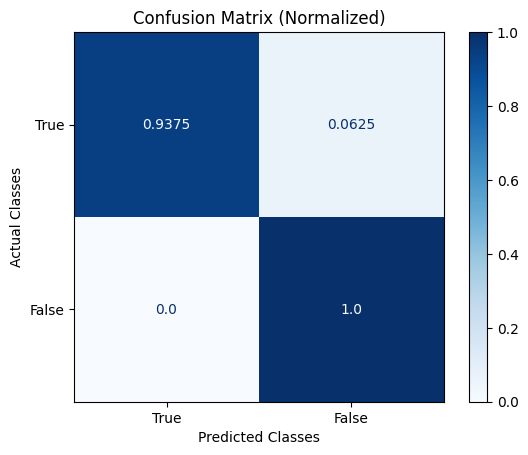

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
from pycm import ConfusionMatrix
from sklearn.metrics import classification_report

confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels, predict_vector=relevance_classifications, classes=['True','False']
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)

In [36]:
true_labels = [str(x) for x in true_labels]
relevance_classifications = [str(x) for x in relevance_classifications]
print(classification_report(true_labels, relevance_classifications, labels=['True', 'False']))

              precision    recall  f1-score   support

        True       1.00      0.94      0.97        16
       False       0.93      1.00      0.97        14

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30

